## <p style="background-color:#D5F5E3; color:black; font-family:cinzel; font-size:250%; text-align:center; border-radius: 5px 20px;">EMAIL SPAM-HAM Classification</p>

<img src="spam_ham_images/spamham1.webp" style="width:100%;">


## <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 5px 20px;">Table of Content</p>
* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning the corpus 🛠](#3.1)
    * [3.2 Stemming 🛠](#3.2)
    * [3.3 All together 🛠](#3.3)
* [4. Tokens visualization 📊](#4)
* [5. Vectorization](#5)
    * [5.1 Tunning CountVectorizer](#5.1)
    * [5.2 TF-IDF](#5.2)
* [6. Modeling](#6)

### <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 5px 20px;">Loading Libraries</p>

In [5]:
from pathlib import Path
# loading pacakages for EDA
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # working with directories and files present in operating system

import re # finding patterns in text using regular expressions
import string # lower case, upper case, punctuation data

import random # generates random numbers, used to shuffle data
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns # data visualizaiton library

# Word Cloud is a plotting library to plot freqency of words 
from wordcloud import WordCloud, STOPWORDS

from PIL import Image # read, write, show Images

import nltk # nltk library for natural language processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# split data into train and test sample
from sklearn.model_selection import train_test_split

# classification metrices for model evaluation
from sklearn import metrics
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    auc,
    roc_curve,
    roc_auc_score
)

# Traditional Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

# showing plots after each shell in jupyter notebook without plt.show() method
%matplotlib inline 
    
STOP_WORDS = set.union(STOPWORDS, stopwords.words("english"))
custom_stop_words = [
    "nbsp", "content", "type", "text", "plain", 
    "charset", "us-ascii", "utf-8", "encoding", "transfer"]
STOP_WORDS.update(custom_stop_words)

<a id='1'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>


In [8]:
dir_path = Path('sms+spam+collection')

file_path = dir_path / "SMSSpamCollection"

In [9]:
df = pd.read_csv(file_path, sep="\t", header=None)
df.columns = ["class", "message"]

In [10]:
df.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<a id='2'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Now we are going to take a look about the target distribution.

In [12]:
df['class'].unique()

array(['ham', 'spam'], dtype=object)

In [13]:
df['class'].value_counts()

class
ham     4825
spam     747
Name: count, dtype: int64

In [14]:
(df['class'].value_counts()) / df.shape[0]

class
ham     0.865937
spam    0.134063
Name: count, dtype: float64

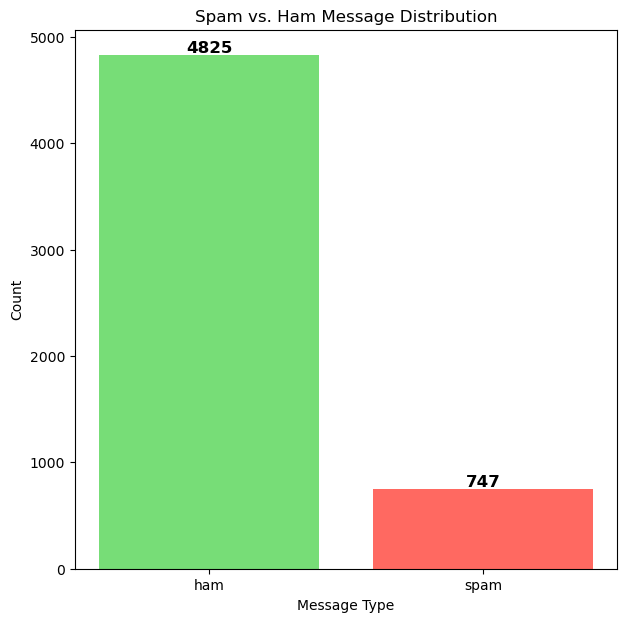

In [15]:
import matplotlib.pyplot as plt

# Count occurrences of each class (Ham & Spam)
class_counts = df['class'].value_counts()

# Plot
plt.figure(figsize=(7, 7))
bars = plt.bar(class_counts.index, class_counts.values, color=['#77DD77', '#FF6961'])

# Add count labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             str(bar.get_height()), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and Title
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.title("Spam vs. Ham Message Distribution")

# Show plot
plt.show()


In [16]:
df['message'] = df['message'].apply(lambda m: m.strip().lower())

In [17]:
df.head()

,class,message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [28]:
df['message_len'] = df['message'].apply(lambda message: len(message))

In [29]:
df.head()

,class,message,message_len
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61


In [30]:
df.groupby('class')['message_len'].describe().style.background_gradient(cmap='binary')

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
ham,4825.000000,71.448497,58.435237,2.000000,33.000000,52.000000,93.000000,910.000000
spam,747.000000,138.629183,28.856451,13.000000,133.000000,149.000000,157.000000,223.000000


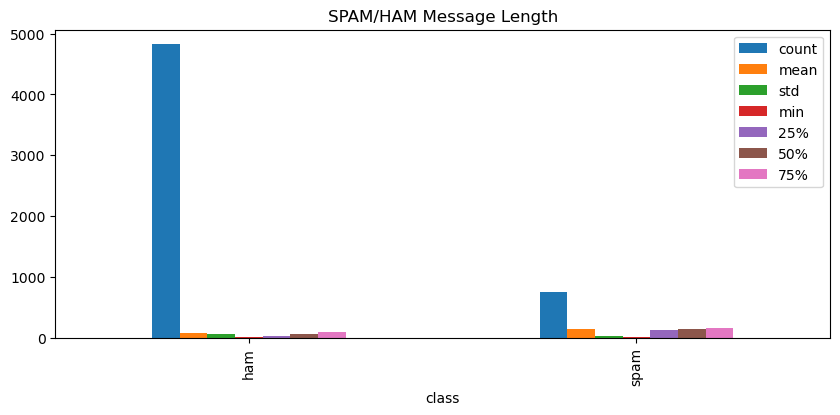

In [31]:
plt.figure(dpi=100, figsize=(10, 4))
plt.title("SPAM/HAM Message Length")
df.groupby('class')['message_len'].describe().drop('max', axis=1).plot(kind='bar', ax=plt.gca())
#plt.yscale('log')
plt.show()

<a id='3'></a>

# <p style="background-color:#D5F5E3; color:black; font-family:monospace; font-size:150%; text-align:center; border-radius: 5px 20px;">3. Data Pre-processing 🛠</p>

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

<a id='3.1'></a>

## <p style="background-color:#D5F5E3; color:black; font-family:monospace; font-size:140%; text-align:center; border-radius: 5px 20px;">3.1 Cleaning the corpus 🛠</p>

In [38]:

def clean_text(message):
    """
        convert text to lowercase for caseless comparisions
        remove hyper links, punctuations, alphanumeric words
    """
    # convert string to lowercase 
    message = str(message).lower()
    # remove all new-line character "\n"
    message = re.sub(r"\r?\n", " ", message)
    message = re.sub(r"<.*?>(.*)</.*?>", r"\1", message)
    message = re.sub(r"<.*?>+", " ", message)
    # remove text presents in any kind of brackets
    message = re.sub(r"\[.*?\]", " ", message)
    message = re.sub(r"\(.*?\)", " ", message)
    message = re.sub(r"\{.*?\}", " ", message)
    # remove url/links from text 
    message = re.sub(r"https?://\S+|www\.\S+", " ", message)
    # remove punctuation letters from string
    message = re.sub(r"[{}]".format(re.escape(string.punctuation)), " ", message)
    # remove all words containing numbers
    message = re.sub(r"\w*\d+\w*", " ", message)
    # remove phone numbers / credit card numbers / etc
    message = re.sub(r"(\d-?)+", " ", message)
    # remove non english characters from text 
    message = re.sub(r"[^a-zA-Z\s]", " ", message)
    # remove all characters having length less than equal 3
    message = re.sub(r"\b\w{0,3}\b", " ", message)
    # merge multiple spaces into one space
    message = re.sub(r"\s+", " ", message)
    return message

In [39]:
df['message'].apply(clean_text)

0        until jurong point crazy available only bugis...
1                                                 joking 
2        free entry wkly comp final tkts text receive ...
3                                     early already then 
4                    think goes lives around here though 
                              ...                        
5567     this time have tried contact have pound prize...
5568                           will going esplanade home 
5569                    pity mood that other suggestions 
5570     some bitching acted like interested buying so...
5571                                      rofl true name 
Name: message, Length: 5572, dtype: object

In [40]:
df.head()

,class,message,message_len
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61


## Stopwords

Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification to reduce noise as frequency of these stop words it way higher in each type of documents which makes it difficult for model to classify a text based on specifi words.
    
#### Removing the stop words them will increase performance of our model


text source: https://docs.python.org/3/tutorial/index.html

<img src="spam_ham_images/stopword.png" style="width:100%;">


In [45]:
def remove_stopwords(message):
    global STOP_WORDS
    clean_message = []
    for word in message.split(" "):
        if word.strip() not in STOP_WORDS:
            clean_message.append(word)
    return " ".join(clean_message)

In [46]:
# example of stop word removal
remove_stopwords("i am awesome as it is like working am to for some thing more")

'awesome working thing'

<a id='3.2'></a>
## <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 5px 20px;">3.2 Stemming 🛠</p>

### Stemming/ Lematization

For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes*. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

**Stemming** usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

<img src="spam_ham_images/stem_lem.jpg" style="width:100%;">


As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.

### Stemming algorithms

There are several stemming algorithms implemented in NLTK Python library:
1. **PorterStemmer** uses *Suffix Stripping* to produce stems. **PorterStemmer is known for its simplicity and speed**. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because *PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems*. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
2. One can generate its own set of rules for any language that is why Python nltk introduced **SnowballStemmers** that are used to create non-English Stemmers!
3. **LancasterStemmer** (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [50]:
from nltk.stem import SnowballStemmer

In [52]:
stem_engine = SnowballStemmer("english")
# example of stemming
stem_engine.stem("play playing plays played")

'play playing plays play'

<a id='3.3'></a>
## <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 5px 20px;">3.3 All together 🛠</p>

In [54]:
def preprocess_message(message, stem_engine=SnowballStemmer("english")):
    # Clean puntuation, urls, and so on
    message = clean_text(message)
    # Remove stopwords
    message = remove_stopwords(message)
    # Stemm all the words in the sentence
    message = stem_engine.stem(message)
    return message

In [56]:
original = """Natural Language Processing or NLP is a branch of Artificial Intelligence which
deal with bridging the machines understanding humans in their Natural Language. Natural Language
can be in form of text or sound, which are used for humans to communicate each other. NLP can
enable humans to communicate to machines in a natural way.

Text Classification is a process involved in Sentiment Analysis. 
It is classification of peoples opinion or expressions into different 
sentiments. Sentiments include Positive, Neutral, and Negative, Review Ratings and Happy,
Sad. Sentiment Analysis can be done on different consumer centered industries to analyse people's
opinion on a particular product or subject.

Natural language processing has its roots in the 1950s. Already in 1950,
Alan Turing published an article titled "Computing Machinery and Intelligence" 
which proposed what is now called the Turing test as a criterion of intelligence, 
a task that involves the automated interpretation and generation of natural language, 
but at the time not articulated as a problem separate from artificial intelligence. 
"""

transformed = preprocess_message(original)
print("Original Text:\n")
print(original)
print("\n", "__"*50, "\n")
print("Transformed Text:\n")
print(transformed)

Original Text:

Natural Language Processing or NLP is a branch of Artificial Intelligence which
deal with bridging the machines understanding humans in their Natural Language. Natural Language
can be in form of text or sound, which are used for humans to communicate each other. NLP can
enable humans to communicate to machines in a natural way.

Text Classification is a process involved in Sentiment Analysis. 
It is classification of peoples opinion or expressions into different 
sentiments. Sentiments include Positive, Neutral, and Negative, Review Ratings and Happy,
Sad. Sentiment Analysis can be done on different consumer centered industries to analyse people's
opinion on a particular product or subject.

Natural language processing has its roots in the 1950s. Already in 1950,
Alan Turing published an article titled "Computing Machinery and Intelligence" 
which proposed what is now called the Turing test as a criterion of intelligence, 
a task that involves the automated interpretati

In [58]:
df["clean_message"] = df['message'].apply(preprocess_message)
df.head()

,class,message,message_len,clean_message
0,ham,"go until jurong point, crazy.. available only ...",111,jurong point crazy available bugis great worl...
1,ham,ok lar... joking wif u oni...,29,joking
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,free entry wkly comp final tkts receive entry...
3,ham,u dun say so early hor... u c already then say...,49,early already
4,ham,"nah i don't think he goes to usf, he lives aro...",61,think goes lives around though


<a id='4'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:monospace; font-size:150%; text-align:center; border-radius: 5px 20px;">4. Tokens Visualization 📊</p>

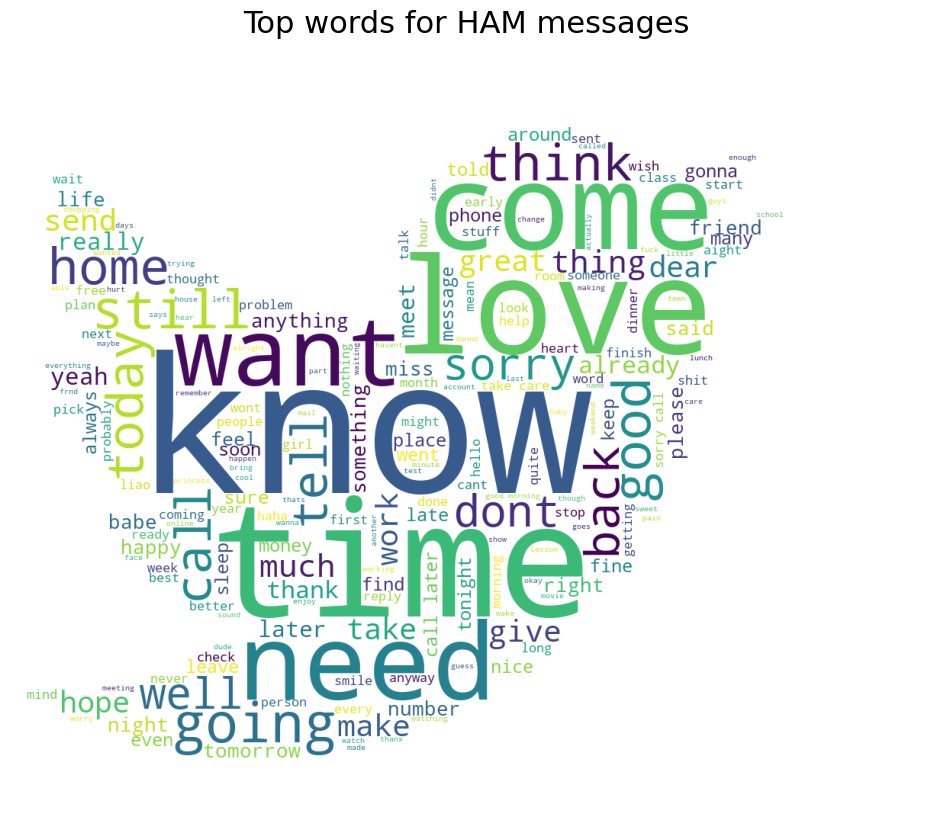

In [60]:
twitter_mask = np.array(Image.open('spam_ham_images/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['class'] == 'ham', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

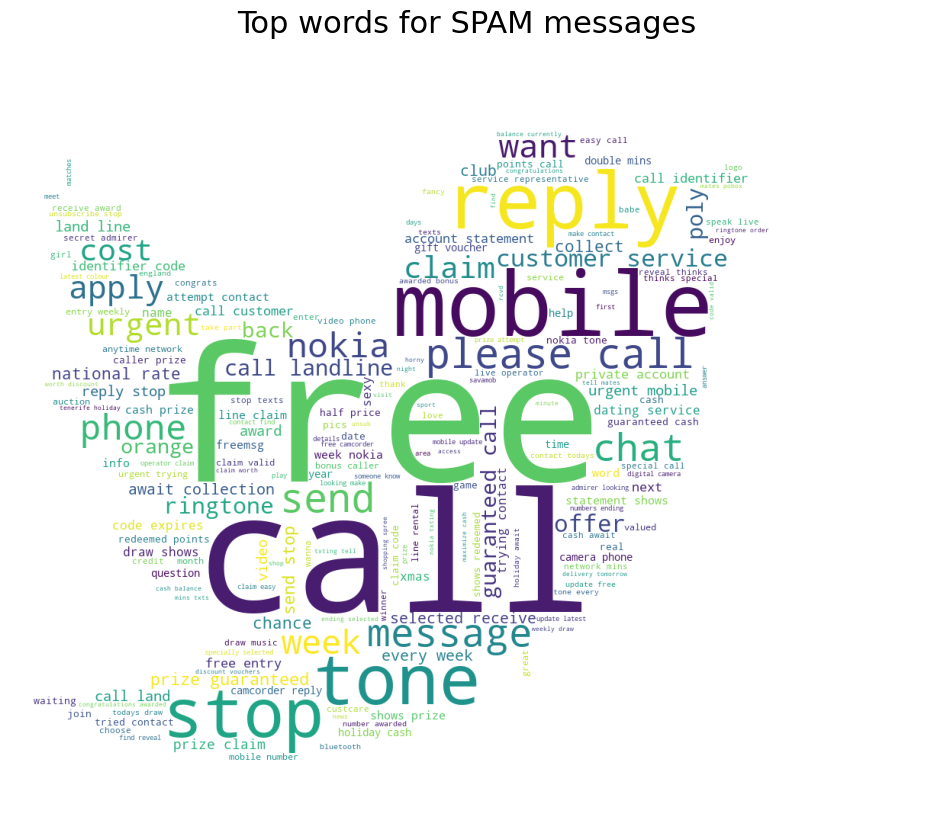

In [63]:
twitter_mask = np.array(Image.open('spam_ham_images/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['class'] == 'spam', 'clean_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='5'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:monospace; font-size:150%; text-align:center; border-radius: 5px 20px;">5. Vectorization</p>

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:



Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

<img src="spam_ham_images/vectorization.png" style="width:100%;">

In [66]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = df['clean_message'].values
y = (df['class'].values == "spam").astype(int)

In [67]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4179 4179
1393 1393


In [68]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer()

In [69]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vectorizer.transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

<a id='5.1'></a>
## <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.1 Tunning CountVectorizer</p>

CountVectorizer has a few parameters you should know.

1. **stop_words**: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. **ngram_range**: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

3. **min_df, max_df**: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. **max_features**: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else. 

You would set these parameters when initializing your CountVectorizer object as shown below.

In [71]:
vectorizer_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.01, max_df=0.2, max_features=1000)

# Use the trained to create a document-term matrix from train and test sets
vectorizer_tunned.fit(X_train)

X_train_dtm = vectorizer_tunned.transform(X_train)
X_test_dtm = vectorizer_tunned.transform(X_test)

<a id='5.2'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.2 TF-IDF</p>

In information retrieval, tf–idf, **TF-IDF**, or TFIDF, **short for term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. 

**tf–idf** is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.


<img src="spam_ham_images/tfidf1.webp" style="width:100%;">

In [73]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<4179x64 sparse matrix of type '<class 'numpy.float64'>'
	with 5216 stored elements in Compressed Sparse Row format>

In [74]:
X_train_tfidf.shape

(4179, 64)

<a id='6'></a>
# <p style="background-color:#D5F5E3; color:black; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

<img src="spam_ham_images/naivebayes.png" style="width:100%;">

In [77]:
# Create a Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [78]:
# Make class anf probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [79]:
cnf = metrics.confusion_matrix(y_test, y_pred_class)

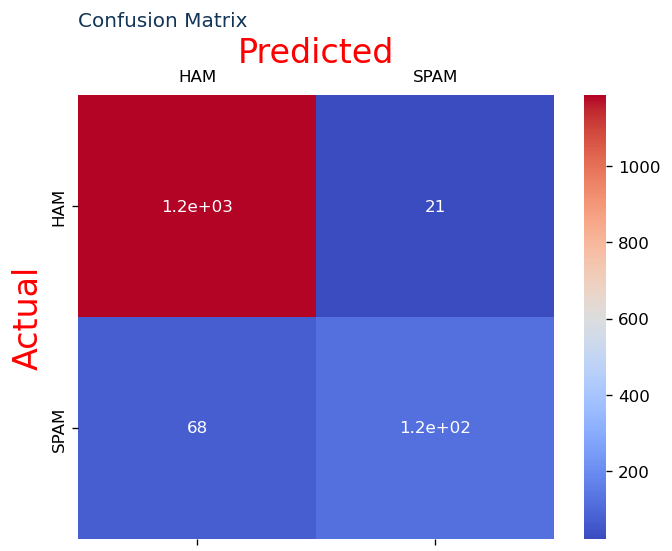

In [80]:
plt.figure(dpi=120)

sns.heatmap(cnf, annot=True, cmap='coolwarm')

plt.xticks([0.5, 1.5], ["HAM", "SPAM"])
plt.gca().xaxis.set_tick_params(labeltop=True)
plt.gca().xaxis.set_tick_params(labelbottom=False)

plt.yticks([0.5, 1.5], ["HAM", "SPAM"])
plt.ylabel("Actual", color='red', fontsize=20)

plt.title("Confusion Matrix", color="#123456", loc='left')

plt.xlabel("Predicted", color='red', fontsize=20)
plt.gca().xaxis.set_label_position('top')

plt.show()

In [81]:
# Accuracy of Model
acc = metrics.accuracy_score(y_test, y_pred_class)
print(f"ACCURACY: {acc:.2f}")

ACCURACY: 0.94


In [82]:
# Calculate AUC
roc_auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC SCORE: {roc_auc_score:.2f}")

ROC-AUC SCORE: 0.87


In [83]:
# Classification Report
clf_report = metrics.classification_report(y_test, y_pred_class)
print(clf_report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1207
           1       0.85      0.63      0.73       186

    accuracy                           0.94      1393
   macro avg       0.90      0.81      0.84      1393
weighted avg       0.93      0.94      0.93      1393

